# Moving to London

## Table of Contents.

1. <a href="#item1">Introduction</a>
2. <a href="#item2">Data preparation</a>
3. <a href="#item3">Analysis</a>
4. <a href="#item4">Results</a>
5. <a href="#item5">Discussion</a>
6. <a href="#item6">Conclusion</a>

<a id="item1"></a>

## 1. Introduction.

### 1.1. Problem declaration.

The family faced the question about moving to London. Having visited city several times it was decided to choose the southern part of the capital. In this research I will try to find several options for possible neighborhoods to move to. The starting point of a comfortable stay will be the current place of living in Saint-Petersburg. The analysis will be made on the basis of open sources such as foursquare, wikipedia and uk government.

### 1.2. Problem discussion. 

To search for the right neighborhoods, I'll use the clustering segmentation. Attributes for segmentation will be common places around current location. To do this, we need to prepare two datasets: <br>
1) with the current place of living and surrounding common venues - bars, restaurants, fitness clubs, supermarkets, etc. <br>
2) London's main neighbourhoods and surrounding public areas are within walking distance.

The list of areas in London is <a href=https://en.wikipedia.org/wiki/List_of_areas_of_London>here</a>.
Data about nearby venues will be recieved from <a href=https://ru.foursquare.com/>Foursquare</a> using API.
Clustering will be done by k-Means method.

After that we will look at the obtained neighborhoods on the map and try to assess their prospects by adding information about their distance from the center.

In the end of the analysis section, I will make a few comparative graphs with rental prices for the resulting neighborhoods and their crime situation based on the open data sets from <a href=https://data.london.gov.uk/dataset>uk.gov site</a> site.

### 1.3. Import Libraries
Python libraries that used in this research.

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 50)
pd.options.mode.chained_assignment = None

import numpy as np

%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

import folium # map rendering library

import requests

from bs4 import BeautifulSoup

import re

#!pip -q install geocoder
import geocoder

from sklearn.cluster import KMeans

<br><br><br>

<a id="item2"></a>

## 2. Data preparation.

Any analysis is impossible without data. In this reserch, we will use both type of data -  historical data showing the dynamics of changes in any factors, and static data, showing the real state of things.
Let's prepare the data and import it into Pandas data frames to use in our analysis.

### 2.1. Dataset 1. Neighborhood data.
The table with London areas is in the Wikipedia pages. The link is <a href=https://en.wikipedia.org/wiki/List_of_areas_of_London>here</a>. <br>
Scrap the data using library BeautifulSoup and record it into Pandas DataFrame.<br>
Field list: <b>Location, London borough, Post town, Postcode district, Dial code, OS grid ref </b>.


In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_areas_of_London'

source = requests.get(url).text

soup = BeautifulSoup(source, 'lxml')

ds_table = soup.find('table',{'class':'wikitable sortable'})

columns = []

for th in ds_table.find_all('th'):
    columns.append(th.text.replace('\n',''))
    
df_neighborhood = pd.DataFrame(columns=columns)
    
for tr in ds_table.find_all('tr'):
    tds = tr.find_all('td')
    if len(tds) > 0:
        df_neighborhood = df_neighborhood.append(pd.Series([tds[0].text.replace('\n',''), 
                                                            tds[1].text.replace('\n',''), 
                                                            tds[2].text.replace('\n',''),
                                                            tds[3].text.replace('\n',''), 
                                                            tds[4].text.replace('\n',''), 
                                                            tds[5].text.replace('\n','')],
                                                           index=df_neighborhood.columns), ignore_index=True)

df_neighborhood.shape

(533, 6)

Let's apply several transformations.

In [3]:
df_neighborhood.rename(columns={df_neighborhood.columns[0]: "Neighborhood"}, inplace = True)
df_neighborhood.rename(columns={df_neighborhood.columns[1]: "Borough"}, inplace = True)
df_neighborhood.rename(columns={df_neighborhood.columns[3]: "Postcode"}, inplace = True)
df_neighborhood['Borough'] = df_neighborhood['Borough'].str.replace('\[.*\]','',regex=True)
df_neighborhood.head()

,Neighborhood,Borough,Post town,Postcode,Dial code,OS grid ref
0,Abbey Wood,"Bexley, Greenwich",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,"W3, W4",020,TQ205805
2,Addington,Croydon,CROYDON,CR0,020,TQ375645
3,Addiscombe,Croydon,CROYDON,CR0,020,TQ345665
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728


As we can see, some rows have more than one value for the Postcode district. We need to split it into different rows.

In [4]:
s = df_neighborhood["Postcode"].str.split(',', expand=True).stack()
i = s.index.get_level_values(0)
df_split = df_neighborhood.loc[i].copy()
df_split["PostcodeSplit"] = s.values
df_split.reset_index(drop=True, inplace=True)
df = df_split[['Neighborhood','Borough','PostcodeSplit']]
df.rename(columns={'PostcodeSplit':'Postcode'}, inplace=True)
df.head()

,Neighborhood,Borough,Postcode
0,Abbey Wood,"Bexley, Greenwich",SE2
1,Acton,"Ealing, Hammersmith and Fulham",W3
2,Acton,"Ealing, Hammersmith and Fulham",W4
3,Addington,Croydon,CR0
4,Addiscombe,Croydon,CR0


Next, we need to get geographical coordinates linked to the postal code. To do this we will use the Geocoder library.<br>
The function for getting geo-coordinates by given string is declared below.<br>
Then we will apply the function to the entire dataframe and get the coordinates for each postcode.

In [5]:
def get_geocoord(postcode):
    lat_lng_coords = None
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, London, United Kingdom'.format(postcode))
        lat_lng_coords = g.latlng
    return lat_lng_coords

In [6]:
columns = ["Postcode", "Latitude", "Longitude"]
df_postcodes = pd.DataFrame(columns=columns)

postcodes = df['Postcode'].unique()

for p in postcodes:
    gc = get_geocoord(p)
    df_postcodes = df_postcodes.append(pd.Series([p, gc[0], gc[1]], index=df_postcodes.columns), ignore_index=True)
                                                  
df_postcodes.head()

,Postcode,Latitude,Longitude
0,SE2,51.492450,0.121270
1,W3,51.513240,-0.267460
2,W4,51.489440,-0.261940
3,CR0,51.384755,-0.051499
4,DA5,51.506420,-0.127210


Let's join dataframes to one. <br>
Filter data by the necessary areas.

In [7]:
df_london = df.merge(df_postcodes, how='left', left_on='Postcode', right_on='Postcode')
df_london = df_london[df_london['Postcode'].str.startswith('SE', na=False) | df_london['Postcode'].str.startswith('SW', na=False)]
df_london.head()

,Neighborhood,Borough,Postcode,Latitude,Longitude
0,Abbey Wood,"Bexley, Greenwich",SE2,51.49245,0.12127
11,Anerley,Bromley,SE20,51.41009,-0.05683
21,Balham,Wandsworth,SW12,51.44822,-0.14839
22,Bankside,Southwark,SE1,51.49996,-0.09568
27,Barnes,Richmond upon Thames,SW13,51.47457,-0.24212


The DataFrame with neighborhoods is ready. Now we can see them on the map below.

In [8]:
london_map = folium.Map(location=[51.509865, -0.118092], zoom_start=11)

for lat, lng, loc, borough in zip(df_london['Latitude'], df_london['Longitude'], df_london['Neighborhood'], df_london['Borough']):
    label = '{}, {}'.format(loc, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(london_map)  
    
london_map

### 2.2. Dataset 2. Nearby Venues.


Using the foursquare service, we can get data about nearby places at the specified coordinates.<br>
Let's request data for each coordinates in dataframe.

In [9]:
CLIENT_ID = 'S1IAIWWW5FFW0LO3GL0V3YOF2WMFIVLFVZ5XOEXL45NFPFBP'
CLIENT_SECRET = 'Q1KB0NM5NAFQTCGGDEIL0QXVPWPGFJQKDZTK3ULT4LY0AOYG'
VERSION = '20200510'

In [10]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000, LIMIT = 100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Prepare dataframe to execution. We need to get rid of duplicates in coordinates.

In [11]:
df_location = df_london[['Neighborhood', 'Borough', 'Latitude', 'Longitude']].groupby("Neighborhood").first().reset_index()
df_location.shape

(107, 4)

Let's execute function and get new DataFrame with London venues

In [13]:
london_venues = getNearbyVenues(names=df_location['Neighborhood'],
                                   latitudes=df_location['Latitude'],
                                   longitudes=df_location['Longitude']
                                  )

Abbey Wood
Anerley
Balham
Bankside
Barnes
Battersea
Belgravia
Bellingham
Bermondsey
Blackheath
Blackheath Royal Standard
Brixton
Brockley
Brompton
Camberwell
Castelnau
Catford
Charlton
Chelsea
Chinbrook
Clapham
Colliers Wood
Crofton Park
Crossness
Crystal Palace
Denmark Hill
Deptford
Dulwich
Earls Court
Earlsfield
East Dulwich
East Sheen
Elephant and Castle
Eltham
Falconwood
Forest Hill
Fulham
Gipsy Hill
Greenwich
Grove Park
Herne Hill
Hither Green
Honor Oak
Horn Park
Kennington
Kensington
Kidbrooke
Kingston Vale
Knightsbridge
Ladywell
Lambeth
Lee
Lewisham
Longlands
Maze Hill
Merton Park
Middle Park
Millbank
Mortlake
Mottingham
New Cross
New Eltham
Newington
Nine Elms
Norbury
Nunhead
Oval
Parsons Green
Peckham
Penge
Pimlico
Plumstead
Putney
Raynes Park
Roehampton
Rotherhithe
Sands End
Selhurst
Shooter's Hill
South Kensington
South Norwood
South Wimbledon
Southend
Southfields
St James's
St Johns
Stockwell
Streatham
Surrey Quays
Sydenham (also Lower Sydenham, Upper Sydenham)
Sydenham Hil

In [14]:
london_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Abbey Wood,51.49245,0.12127,Lesnes Abbey,51.489526,0.125839,Historic Site
1,Abbey Wood,51.49245,0.12127,Lidl,51.496152,0.118417,Supermarket
2,Abbey Wood,51.49245,0.12127,Sainsbury's,51.492826,0.120524,Supermarket
3,Abbey Wood,51.49245,0.12127,Abbey Wood Railway Station (ABW),51.490825,0.123432,Train Station
4,Abbey Wood,51.49245,0.12127,Co-op Food,51.487650,0.113490,Grocery Store


Now we need to add information about current location and venues around it.

In [15]:
df_current = pd.DataFrame({'name': ['Current Location'], 'lat': [60.00423210323719], 'long': [30.213402756825666]})
current_venues = getNearbyVenues(names=df_current['name'],
                                   latitudes=df_current['lat'],
                                   longitudes=df_current['long']
                                  )

Current Location


In [16]:
current_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Current Location,60.004232,30.213403,Sculptors,60.004505,30.212685,Gym / Fitness Center
1,Current Location,60.004232,30.213403,Приморский культурный центр,60.006417,30.213843,Event Space
2,Current Location,60.004232,30.213403,Людилюбят,60.005993,30.211052,Bakery
3,Current Location,60.004232,30.213403,ВкусВилл,60.000648,30.208976,Health Food Store
4,Current Location,60.004232,30.213403,Ароматный Мир,60.005144,30.210450,Wine Shop


Combine the datasets. In the future we will need it for clustering.

In [41]:
df_union = pd.concat([london_venues, current_venues])
df_union.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Abbey Wood,51.49245,0.12127,Lesnes Abbey,51.489526,0.125839,Historic Site
1,Abbey Wood,51.49245,0.12127,Lidl,51.496152,0.118417,Supermarket
2,Abbey Wood,51.49245,0.12127,Sainsbury's,51.492826,0.120524,Supermarket
3,Abbey Wood,51.49245,0.12127,Abbey Wood Railway Station (ABW),51.490825,0.123432,Train Station
4,Abbey Wood,51.49245,0.12127,Co-op Food,51.487650,0.113490,Grocery Store


### 2.3. Dataset 3. London Crime data.

Data about London crimes for last 24 months for each borough. This dataframe is consist of historycal data about London crimes in each month. Using it we can see how the number of crimes has changed over time in each borough.

In [18]:
df_london_crime = pd.read_csv('https://data.london.gov.uk/download/recorded_crime_summary/d2e9ccfc-a054-41e3-89fb-53c2bc3ed87a/MPS%20Borough%20Level%20Crime%20%28most%20recent%2024%20months%29.csv')

In [19]:
df_london_crime.head()

,MajorText,MinorText,LookUp_BoroughName,201805,201806,201807,201808,201809,201810,201811,201812,201901,201902,201903,201904,201905,201906,201907,201908,201909,201910,201911,201912,202001,202002,202003,202004
0,Arson and Criminal Damage,Arson,Barking and Dagenham,4,12,6,5,3,8,5,1,5,2,5,5,11,3,5,3,6,9,8,6,4,5,6,2
1,Arson and Criminal Damage,Criminal Damage,Barking and Dagenham,126,123,127,101,107,132,105,88,97,127,138,130,139,113,134,118,109,109,97,121,97,103,108,82
2,Burglary,Burglary - Business and Community,Barking and Dagenham,24,33,30,18,33,32,39,33,45,24,29,27,22,27,31,35,37,30,30,25,31,17,27,29
3,Burglary,Burglary - Residential,Barking and Dagenham,93,77,94,84,99,94,106,164,114,107,99,96,114,96,71,67,80,97,114,130,116,123,97,56
4,Drug Offences,Drug Trafficking,Barking and Dagenham,8,6,8,7,10,7,7,4,5,2,6,5,9,6,11,7,7,10,12,3,11,3,6,9


### 2.4. Dataset 4. London average rents by borough.

Data about London neighborhood rent prices.<br>
This Dataаrame includes data about the types of apartments and their median prices in the context of dates.

In [20]:
df_rent_prices = pd.read_excel('https://data.london.gov.uk/download/average-private-rents-borough/73b9fb07-b5bb-4a53-88b7-c17269879a08/voa-average-rent-borough.xls'
                              , sheet_name='Raw data'
                              , skiprows = 2)

In [21]:
df_rent_prices.head()

,Year,Quarter,Code,Area,Category,Count of rents,Average,Lower quartile,Median,Upper quartile
0,2011,Q2,E09000001,City of London,Room,-,-,-,-,-
1,2011,Q2,E09000002,Barking and Dagenham,Room,92,336,282,347,390
2,2011,Q2,E09000003,Barnet,Room,945,450,399,433,500
3,2011,Q2,E09000004,Bexley,Room,119,390,347,390,433
4,2011,Q2,E09000005,Brent,Room,344,469,390,457,550


<br><br><br>

<a id="item3"></a>

## 3. Analysis.

In this section of the analysis, we will do the main work on selecting a suitable place of living. Based on clustering segmentation, we will identify several clusters. To do this, we will use k-means clustering.
After that, we will several analysis on the results obtained to narrow the resultset. We will conduct a comparative analysis of the characteristics of the borough - prices for renting apartments and the criminogenic situation. It will help us to choose our final goal in the future.

### 3.1. Preparation dataset for clustering.
We need to prepare dataset for segmentation.<br>
Apply one-hot encoding to dataframe.

In [23]:
df_onehot = pd.get_dummies(df_union[['Venue Category']], prefix="", prefix_sep="")

df_onehot['Neighborhood'] = df_union['Neighborhood'] 

fixed_columns = [df_onehot.columns[-1]] + list(df_onehot.columns[:-1])
df_onehot = df_onehot[fixed_columns]

df_onehot.head()

,Neighborhood,African Restaurant,American Restaurant,Antique Shop,Aquarium,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Beach,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,...,Theme Park Ride / Attraction,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Track,Trail,Train Station,Tram Station,Tree,Tunnel,Turkish Restaurant,University,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Windmill,Wine Bar,Wine Shop,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio
0,Abbey Wood,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Abbey Wood,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Abbey Wood,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Abbey Wood,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Abbey Wood,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [24]:
grouped_df = df_onehot.groupby('Neighborhood').mean().reset_index()
grouped_df

,Neighborhood,African Restaurant,American Restaurant,Antique Shop,Aquarium,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Beach,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,...,Theme Park Ride / Attraction,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Track,Trail,Train Station,Tram Station,Tree,Tunnel,Turkish Restaurant,University,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Windmill,Wine Bar,Wine Shop,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio
0,Abbey Wood,0.000000,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.000000,0.000,0.0,0.00,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000,0.0,0.090909,0.000,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.000000
1,Anerley,0.000000,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.000000,0.000,0.0,0.00,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000,0.0,0.100000,0.075,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.000000
2,Balham,0.000000,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.010204,0.000,0.0,0.00,0.0,0.0,0.051020,0.030612,0.0,0.000000,0.0,0.010204,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000,0.0,0.000000,0.000,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.000000,0.0,0.0,0.0,0.00,0.020408,0.0,0.0,0.0,0.020408
3,Bankside,0.000000,0.01,0.0,0.0,0.0,0.02,0.0,0.03,0.00,0.020000,0.000,0.0,0.01,0.0,0.0,0.010000,0.000000,0.0,0.010000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000,0.0,0.000000,0.000,0.0,0.0,0.00,0.0,0.01,0.0,0.00,0.010000,0.0,0.0,0.0,0.02,0.000000,0.0,0.0,0.0,0.000000
4,Barnes,0.000000,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.000000,0.025,0.0,0.00,0.0,0.0,0.025000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.025,0.0,0.025000,0.000,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,West Norwood,0.000000,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.000000,0.000,0.0,0.00,0.0,0.0,0.076923,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000,0.0,0.025641,0.000,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.000000
104,Westcombe Park,0.000000,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.000000,0.000,0.0,0.00,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000,0.0,0.000000,0.000,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.000000
105,Westminster,0.000000,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.01,0.010000,0.000,0.0,0.00,0.0,0.0,0.010000,0.010000,0.0,0.020000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000,0.0,0.000000,0.000,0.0,0.0,0.01,0.0,0.00,0.0,0.00,0.000000,0.0,0.0,0.0,0.01,0.000000,0.0,0.0,0.0,0.000000
106,Wimbledon,0.000000,0.00,0.0,0.0,0.0,0.01,0.0,0.00,0.00,0.010000,0.000,0.0,0.00,0.0,0.0,0.030000,0.030000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000,0.0,0.000000,0.000,0.0,0.0,0.00,0.0,0.01,0.0,0.01,0.010000,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.000000


In [25]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's find top-ten most common venues.

In [26]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = grouped_df['Neighborhood']

for ind in np.arange(grouped_df.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(grouped_df.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(50)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Abbey Wood,Supermarket,Coffee Shop,Train Station,Historic Site,Lake,Convenience Store,Platform,Grocery Store,Campground,Pub
1,Anerley,Pub,Train Station,Grocery Store,Pizza Place,Supermarket,Tram Station,Convenience Store,Hardware Store,Park,Coffee Shop
2,Balham,Coffee Shop,Pub,Grocery Store,Pizza Place,Bakery,Supermarket,Indian Restaurant,Restaurant,Italian Restaurant,Bar
3,Bankside,Pub,Italian Restaurant,Hotel,Coffee Shop,Theater,Gym / Fitness Center,Café,Seafood Restaurant,Art Museum,Restaurant
4,Barnes,Park,Pub,Platform,Grocery Store,Coffee Shop,Farmers Market,Pizza Place,Bus Stop,Café,Soccer Field
5,Battersea,Italian Restaurant,Bakery,Coffee Shop,Café,French Restaurant,Cocktail Bar,Bar,Indian Restaurant,Pizza Place,Burger Joint
6,Belgravia,Hotel,Coffee Shop,Café,Theater,Historic Site,Pub,Sushi Restaurant,Garden,Restaurant,Sandwich Place
7,Bellingham,Grocery Store,Train Station,Coffee Shop,Italian Restaurant,Bus Stop,Furniture / Home Store,Supermarket,Park,Pizza Place,Japanese Restaurant
8,Bermondsey,Pub,Italian Restaurant,Hotel,Coffee Shop,Theater,Gym / Fitness Center,Café,Seafood Restaurant,Art Museum,Restaurant
9,Blackheath,Café,Pub,Grocery Store,Lake,Bus Stop,Furniture / Home Store,Supermarket,Chinese Restaurant,Park,Fast Food Restaurant


### 3.2. Applying k-means clustering.

In [27]:
# set number of clusters
kclusters = 6

clustering_df = grouped_df.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(clustering_df)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 1, 2, 4, 2, 2, 0, 2, 3], dtype=int32)

In [28]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [29]:
df_merged = neighborhoods_venues_sorted
df_merged = df_merged.join(df_location.set_index('Neighborhood'), on='Neighborhood', how='left')

df_merged['Cluster Labels'] = df_merged['Cluster Labels'].astype(int)
df_merged

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Borough,Latitude,Longitude
0,0,Abbey Wood,Supermarket,Coffee Shop,Train Station,Historic Site,Lake,Convenience Store,Platform,Grocery Store,Campground,Pub,"Bexley, Greenwich",51.49245,0.12127
1,0,Anerley,Pub,Train Station,Grocery Store,Pizza Place,Supermarket,Tram Station,Convenience Store,Hardware Store,Park,Coffee Shop,Bromley,51.41009,-0.05683
2,1,Balham,Coffee Shop,Pub,Grocery Store,Pizza Place,Bakery,Supermarket,Indian Restaurant,Restaurant,Italian Restaurant,Bar,Wandsworth,51.44822,-0.14839
3,2,Bankside,Pub,Italian Restaurant,Hotel,Coffee Shop,Theater,Gym / Fitness Center,Café,Seafood Restaurant,Art Museum,Restaurant,Southwark,51.49996,-0.09568
4,4,Barnes,Park,Pub,Platform,Grocery Store,Coffee Shop,Farmers Market,Pizza Place,Bus Stop,Café,Soccer Field,Richmond upon Thames,51.47457,-0.24212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,1,West Norwood,Grocery Store,Coffee Shop,Pub,Bakery,Italian Restaurant,Portuguese Restaurant,Sporting Goods Shop,Café,Sandwich Place,Convenience Store,Lambeth,51.43407,-0.10375
104,3,Westcombe Park,Café,Pub,Grocery Store,Lake,Bus Stop,Furniture / Home Store,Supermarket,Chinese Restaurant,Park,Fast Food Restaurant,Greenwich,51.47138,0.02338
105,2,Westminster,Hotel,Coffee Shop,Café,Theater,Historic Site,Pub,Sushi Restaurant,Garden,Restaurant,Sandwich Place,Westminster,51.49714,-0.13829
106,2,Wimbledon,Pub,Coffee Shop,Italian Restaurant,Café,Sushi Restaurant,Thai Restaurant,Bakery,Burger Joint,Supermarket,Grocery Store,Merton,51.42170,-0.20796


To find out which cluster we are interested in, we need to find a row with the current place of living

In [30]:
df_merged[df_merged['Neighborhood']=='Current Location']

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Borough,Latitude,Longitude
25,2,Current Location,Bakery,Hookah Bar,Wine Shop,Eastern European Restaurant,Pet Store,Caucasian Restaurant,Beer Store,Mountain,Flower Shop,Pharmacy,NaN,NaN,NaN


Now we can see the result of clustering on map below.

### 3.3. Clustering result.

In [31]:
df_london_cluster = df_merged.dropna()
df_london_cluster.head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Borough,Latitude,Longitude
0,0,Abbey Wood,Supermarket,Coffee Shop,Train Station,Historic Site,Lake,Convenience Store,Platform,Grocery Store,Campground,Pub,"Bexley, Greenwich",51.49245,0.12127
1,0,Anerley,Pub,Train Station,Grocery Store,Pizza Place,Supermarket,Tram Station,Convenience Store,Hardware Store,Park,Coffee Shop,Bromley,51.41009,-0.05683
2,1,Balham,Coffee Shop,Pub,Grocery Store,Pizza Place,Bakery,Supermarket,Indian Restaurant,Restaurant,Italian Restaurant,Bar,Wandsworth,51.44822,-0.14839
3,2,Bankside,Pub,Italian Restaurant,Hotel,Coffee Shop,Theater,Gym / Fitness Center,Café,Seafood Restaurant,Art Museum,Restaurant,Southwark,51.49996,-0.09568
4,4,Barnes,Park,Pub,Platform,Grocery Store,Coffee Shop,Farmers Market,Pizza Place,Bus Stop,Café,Soccer Field,Richmond upon Thames,51.47457,-0.24212


In [32]:
# create map
map_clusters = folium.Map(location=[51.509865, -0.118092], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, borough in zip(df_london_cluster['Latitude'], df_london_cluster['Longitude'], df_london_cluster['Neighborhood'], df_london_cluster['Cluster Labels'], df_london_cluster['Borough']):
    label = folium.Popup(str(poi) + '. Borough: ' +  str(borough) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [33]:
df_london_cluster.loc[df_london_cluster['Cluster Labels'] == 2]

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Borough,Latitude,Longitude
3,2,Bankside,Pub,Italian Restaurant,Hotel,Coffee Shop,Theater,Gym / Fitness Center,Café,Seafood Restaurant,Art Museum,Restaurant,Southwark,51.49996,-0.09568
5,2,Battersea,Italian Restaurant,Bakery,Coffee Shop,Café,French Restaurant,Cocktail Bar,Bar,Indian Restaurant,Pizza Place,Burger Joint,Wandsworth,51.46760,-0.16290
6,2,Belgravia,Hotel,Coffee Shop,Café,Theater,Historic Site,Pub,Sushi Restaurant,Garden,Restaurant,Sandwich Place,Westminster,51.49714,-0.13829
8,2,Bermondsey,Pub,Italian Restaurant,Hotel,Coffee Shop,Theater,Gym / Fitness Center,Café,Seafood Restaurant,Art Museum,Restaurant,Southwark,51.49996,-0.09568
13,2,Brompton,French Restaurant,Café,Hotel,English Restaurant,Bakery,Bookstore,Pub,Plaza,Italian Restaurant,Ice Cream Shop,Kensington and ChelseaHammersmith and Fulham,51.49014,-0.16248
18,2,Chelsea,French Restaurant,Café,Hotel,English Restaurant,Bakery,Bookstore,Pub,Plaza,Italian Restaurant,Ice Cream Shop,Kensington and Chelsea,51.49014,-0.16248
20,2,Clapham,Restaurant,Coffee Shop,Japanese Restaurant,Burger Joint,Italian Restaurant,Pizza Place,Bakery,Tapas Restaurant,Café,Gastropub,"Lambeth, Wandsworth",51.46095,-0.13922
21,2,Colliers Wood,Pub,Coffee Shop,Italian Restaurant,Café,Sushi Restaurant,Thai Restaurant,Bakery,Burger Joint,Supermarket,Grocery Store,Merton,51.42170,-0.20796
29,2,Earls Court,Hotel,Garden,Pub,Italian Restaurant,Bakery,Café,Thai Restaurant,Burger Joint,Pizza Place,Tapas Restaurant,Kensington and Chelsea,51.49004,-0.18971
33,2,Elephant and Castle,Pub,Italian Restaurant,Hotel,Coffee Shop,Theater,Gym / Fitness Center,Café,Seafood Restaurant,Art Museum,Restaurant,Southwark,51.49996,-0.09568


### 3.4. Cluster on the map.
Now we can explore cluster on the map.<br>
Let's add two circles on the map that illustrate the minimum and maximum distance from the city center. These distances were chosen for personal reasons of comfortable distance from the center.

As we can see on the map below the neighborhoods and their boroughs satisfying chosen distances are:<br>
1) Neighborhood: Earls Court. Borough: Kensington and Chelsea.<br>
2) Neighborhood: South Kensington. Borough: Kensington and Chelsea.<br>
3) Neighborhood: Chelsea. Borough: Kensington and Chelsea.<br>
4) Neighborhood: Battersea. Borough: Wandsworth.<br>
5) Neighborhood: Clapham. Borough: Lambeth.<br> 

In [34]:
df_cluster2 = df_london_cluster[df_london_cluster['Cluster Labels']==2]

# create map
map_clusters = folium.Map(location=[51.509865, -0.118092], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, borough in zip(df_cluster2['Latitude'], df_cluster2['Longitude'], df_cluster2['Neighborhood'], df_cluster2['Cluster Labels'], df_cluster2['Borough']):
    label = folium.Popup(str(poi) + '. Borough: ' + str(borough) + '. Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

folium.Circle([51.509865, -0.118092],
                    radius=2500,
                    color='red'
                   ).add_to(map_clusters)

folium.Circle([51.509865, -0.118092],
                    radius=6000,
                    color='red'
                   ).add_to(map_clusters)
    
map_clusters



### 3.5. The apartment rental prices data in the London boroughs.
Now let's evaluate prices for neighborhoods.

In [35]:
df_rent_prices.head()

,Year,Quarter,Code,Area,Category,Count of rents,Average,Lower quartile,Median,Upper quartile
0,2011,Q2,E09000001,City of London,Room,-,-,-,-,-
1,2011,Q2,E09000002,Barking and Dagenham,Room,92,336,282,347,390
2,2011,Q2,E09000003,Barnet,Room,945,450,399,433,500
3,2011,Q2,E09000004,Bexley,Room,119,390,347,390,433
4,2011,Q2,E09000005,Brent,Room,344,469,390,457,550


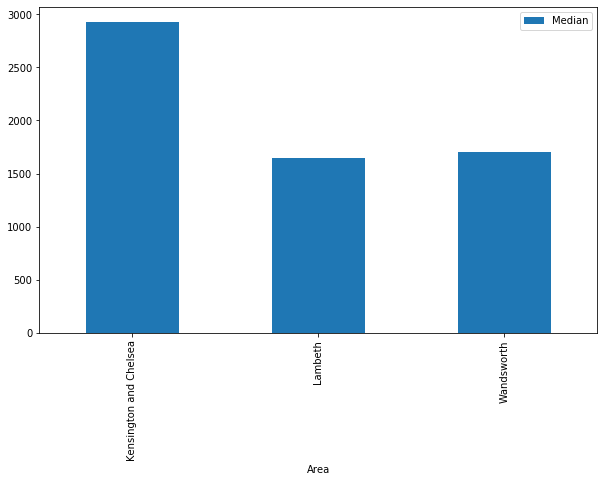

In [36]:
df_prices_chart_bar = df_rent_prices[(df_rent_prices["Year"] == 2019) & (df_rent_prices['Category'] == 'Two Bedroom')][['Area','Median']]
df_prices_chart_bar[df_prices_chart_bar['Area'].isin(['Kensington and Chelsea', 'Wandsworth', 'Lambeth'])].set_index('Area').plot(kind='bar', figsize=(10, 6))

And let's look at the dynamics of price changes over the past few years.

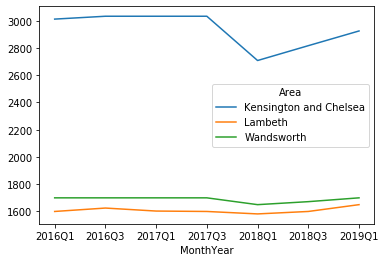

In [37]:
df_prices_chart_line = df_rent_prices[(df_rent_prices["Year"].isin([2016, 2017, 2018, 2019])) & (df_rent_prices['Category'] == 'Two Bedroom')][['Quarter', 'Year','Area','Median']]
df_prices_chart_line = df_prices_chart_line[df_prices_chart_line['Area'].isin(['Kensington and Chelsea', 'Wandsworth', 'Lambeth'])]
df_prices_chart_line['MonthYear'] = df_prices_chart_line[['Year', 'Quarter']]\
    .apply(lambda x: ''.join(str(value) for value in x), axis=1)
df_prices_chart_line = df_prices_chart_line[['MonthYear','Area','Median']]

df_prices_chart_line = df_prices_chart_line.pivot(index='MonthYear', columns='Area', values='Median')

df_prices_chart_line.plot()

As we can see on charts, Kensington and Chelsea is extremely expensive borough in rent. Wandsworth and Lambeth are cheaper.<br>
Over the past four years the price dynamics have roughly coincided for all three boroughs.

In [38]:
df_london_crime.head()

,MajorText,MinorText,LookUp_BoroughName,201805,201806,201807,201808,201809,201810,201811,201812,201901,201902,201903,201904,201905,201906,201907,201908,201909,201910,201911,201912,202001,202002,202003,202004
0,Arson and Criminal Damage,Arson,Barking and Dagenham,4,12,6,5,3,8,5,1,5,2,5,5,11,3,5,3,6,9,8,6,4,5,6,2
1,Arson and Criminal Damage,Criminal Damage,Barking and Dagenham,126,123,127,101,107,132,105,88,97,127,138,130,139,113,134,118,109,109,97,121,97,103,108,82
2,Burglary,Burglary - Business and Community,Barking and Dagenham,24,33,30,18,33,32,39,33,45,24,29,27,22,27,31,35,37,30,30,25,31,17,27,29
3,Burglary,Burglary - Residential,Barking and Dagenham,93,77,94,84,99,94,106,164,114,107,99,96,114,96,71,67,80,97,114,130,116,123,97,56
4,Drug Offences,Drug Trafficking,Barking and Dagenham,8,6,8,7,10,7,7,4,5,2,6,5,9,6,11,7,7,10,12,3,11,3,6,9


### 3.6. Crime data for London boroughs.
Total crimes by chosen boroughs.

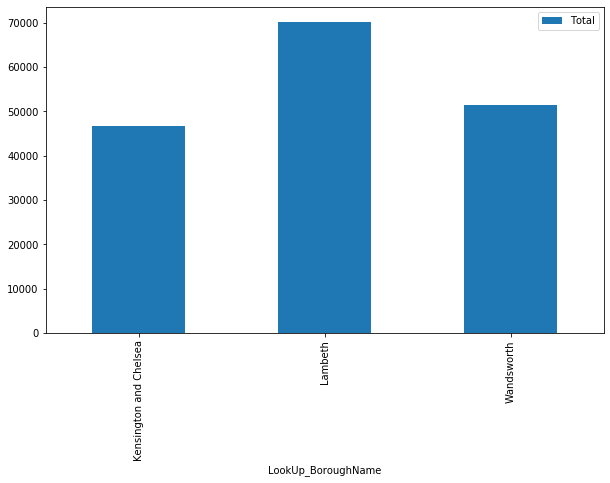

In [39]:
df_london_crime['Total'] = df_london_crime[df_london_crime.columns.drop(['MajorText','MinorText','LookUp_BoroughName'])].sum(axis=1).astype(int)

df_london_crime_bar = df_london_crime[['LookUp_BoroughName','Total']].groupby('LookUp_BoroughName', as_index=False).sum()
df_london_crime_bar.head()

df_london_crime_bar = df_london_crime_bar[df_london_crime_bar['LookUp_BoroughName'].isin(['Kensington and Chelsea', 'Wandsworth', 'Lambeth'])].set_index('LookUp_BoroughName')

df_london_crime_bar.plot(kind='bar', figsize=(10, 6))


Crime types by boroughs.

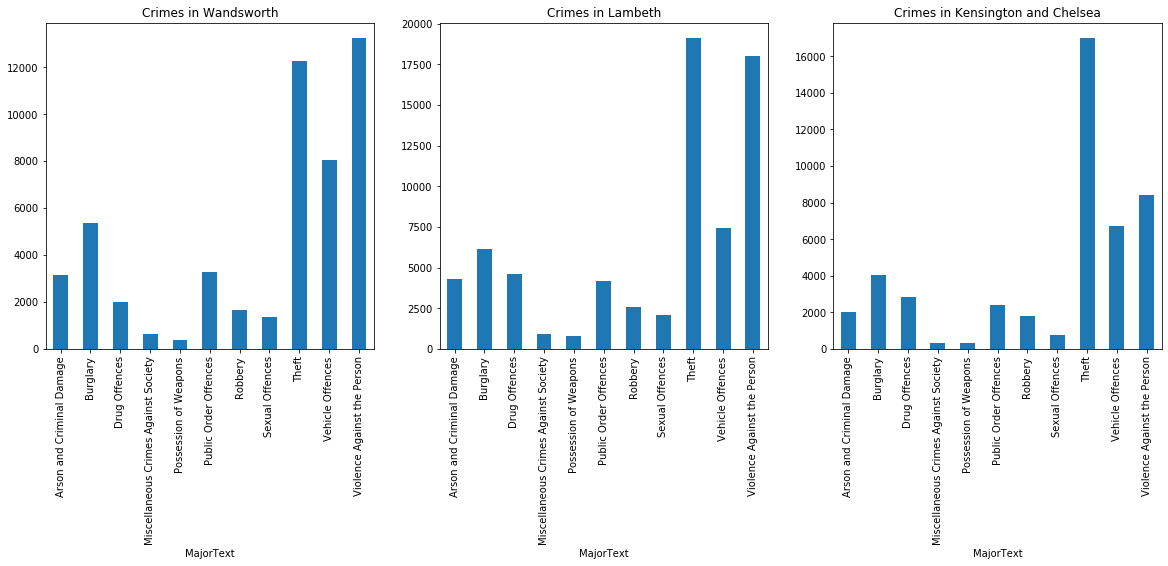

In [40]:
fig = plt.figure() # create figure

ax0 = fig.add_subplot(1, 3, 1) # add subplot 1 (1 row, 2 columns, first plot)
ax1 = fig.add_subplot(1, 3, 2) # add subplot 2 (1 row, 2 columns, second plot). See tip below**
ax2 = fig.add_subplot(1, 3, 3) # add subplot 2 (1 row, 2 columns, second plot). See tip below**

#1
df_london_crime_bar1 = df_london_crime[df_london_crime['LookUp_BoroughName']=='Wandsworth'][['MajorText','Total']].groupby('MajorText', axis=0).sum()
ax0.set_title('Crimes in Wandsworth')
df_london_crime_bar1['Total'].plot(kind='bar', figsize=(20,6), ax=ax0)

#2
df_london_crime_bar2 = df_london_crime[df_london_crime['LookUp_BoroughName']=='Lambeth'][['MajorText','Total']].groupby('MajorText', axis=0).sum()
ax1.set_title('Crimes in Lambeth')
df_london_crime_bar2['Total'].plot(kind='bar', figsize=(20,6), ax=ax1)

#3
df_london_crime_bar3 = df_london_crime[df_london_crime['LookUp_BoroughName']=='Kensington and Chelsea'][['MajorText','Total']].groupby('MajorText', axis=0).sum()
ax2.set_title('Crimes in Kensington and Chelsea')
df_london_crime_bar3['Total'].plot(kind='bar', figsize=(20,6), ax=ax2)

As we can see on the charts above, most crimes happened in Lambeth. In Kensington and Chelsea has less cases and <b>Theft</b> is more frequently.

<br><br><br>

<a id="item4"></a>

## 4. Results.

In this research we tried to determine the most comfortable areas for moving to London from St. Petersburg. <br>
Based on cluster segmentation, we have selected several neighborhoods that satisfy our conditions - the proximity of venues, so that the family does not feel a shortage of anything from the previous area in the new place of living. <br>
Using the minimum and maximum distance from the city center, we have reduced our resultset to three borough - Kensington and Chelsea, Lambeth, Wandsworth. <br>
After conducting a comparative analysis of rental apartment prices, we conclude that the neighborhoods of the borough of Kensington and Chelsea have the highest prices.
The dynamics of price changes shows that prices in the medium term are stable and it is a insignificant factor when choosing an apartment.<br>
We conducted a comparative analysis of the criminal situation in the districts. As you can see from the charts - most crimes happened in Lambeth.<br>
<br>
Based on the received data, you can build a list of priorities in this way:<br>
1) Wandsworth, since this borough has the least crimes and is not the most expensive.<br>
2) Kensington and Chelsea, despite the fact that this is the most expensive borough, crimes are still committed less often in it.<br>
3) Lambeth, an unfavorable borough, but also the prices for apartments are the lowest.

<br><b><br>

<a id="item5"></a>

## 5. Discussion

In large modern cities it is difficult to find borough that differs greatly from each other by the criterion of the presence or absence of any venue categories. Without having visited the city once, it is impossible to choose a place remotely where you would like to live comfortably. Perhaps, for such complex tasks it would be appropriate to add priority to each category, so as to prioritize not by the fact of the availability of any venues, but by the importance for the family.<br>
Moreover, distance to work will be an important criteria. Since this characteristic was not set initially, I added a distance from the city center. In large cities the time to get to work takes up a decent part of the day.<br>
Perhaps, the comparative analyses of boroughs which has been carried out is not enough to fully understand the situation. You can add to the consideration such characteristics as nationality and religion of people in each borough.

<br><br><br>

<a id="item6"></a>

## 6. Conclusion

In this report we made some work to identify similar neighborhoods in two different cities. Cluster segmentation was selected as the definition method. As a result we received a list of boroughs that meet the conditions. Then we analyzed the received boroughs and looked at them from different angles. Based on the data obtained, we have prepared a list of priority boroughs.